<a href="https://colab.research.google.com/github/OscarBedford/MLCourse_Weekly_Exercises/blob/main/Exercise6_5_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 5- Same as 1, but implementing nested cross-validation, with an outer CV loop that
splits the data using 10-fold cross-validation, and an inner CV loop that splits the training set
again in a nested fashion using 5-fold CV. The inner CV loop should select the best
hyperparameter C using grid search (try GridSearchCV with 10 choices for C), and the
outer CV loop should use the best hyperparameter to estimate the true out-of-sample
performance. Plot the mean out-of-sample performance obtained by the outer loop across
models (x axis: the different atlas resolutions, y axis: mean prediction accuracy across 10
test sets).

In [ ]:
!pip install nilearn

In [ ]:
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib

In [ ]:
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [ ]:
# We prepare the model with the required parameters and the cross-validators
logreg = LogisticRegression(max_iter=1e4, penalty = 'l2', C = 1, solver = 'saga')
cv_outer = KFold(n_splits=10, shuffle = True, random_state=1)
cv_inner = KFold(n_splits=5, shuffle = True, random_state=1)

In [ ]:
# We define the iterating variable
ROIs = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [ ]:
# We pre-allocate the variables we want to populate with accuracy scores
k_scores = []

In [ ]:
for x in ROIs:
    brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
    yeo = datasets.fetch_atlas_schaefer_2018(n_rois=(x)) # We iterate through the number of ROIs
    masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
    input_variables = masker.fit_transform(brain_data.gray_matter_maps)
    output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int) # gives 1 for females and 0 for males

    X, y = input_variables, output_variable
    X = scaler.fit_transform(X)
    # We define the search grid
    grid={"C":np.logspace(-3,3,10)}
    # We define search
    search = GridSearchCV(logreg, grid, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True) # We refit the model best on the best value of 'C'
    # We execute the nested cross-validation and store the outer model scores
    scores = cross_val_score(search, X, y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
    scores = np.multiply(scores, 100)
    k_scores.append(scores) 

In [ ]:
# Let's have a look at the accuracies for each of the 10 outer k-folds
k_scores

[array([60., 80., 90., 50., 40., 40., 50., 70., 80., 70.]),
 array([70., 80., 70., 50., 70., 60., 50., 70., 90., 70.]),
 array([70., 90., 70., 50., 30., 70., 50., 70., 80., 70.]),
 array([70., 90., 80., 50., 30., 50., 50., 70., 90., 70.]),
 array([70., 90., 80., 50., 30., 40., 50., 60., 80., 70.]),
 array([80., 90., 70., 40., 50., 30., 50., 60., 90., 70.]),
 array([80., 90., 70., 50., 50., 70., 50., 70., 70., 70.]),
 array([80., 90., 90., 50., 50., 40., 50., 60., 80., 80.]),
 array([ 80.,  80.,  70.,  50.,  50.,  50., 100.,  60.,  80.,  70.]),
 array([70., 90., 90., 50., 50., 30., 70., 70., 90., 70.])]

On the whole, and excluding the single classification accuracy of 100% in the 900-ROI model, the second and second-to-last k-folds yield the highest test set classification accuracies (90% in most cases). 

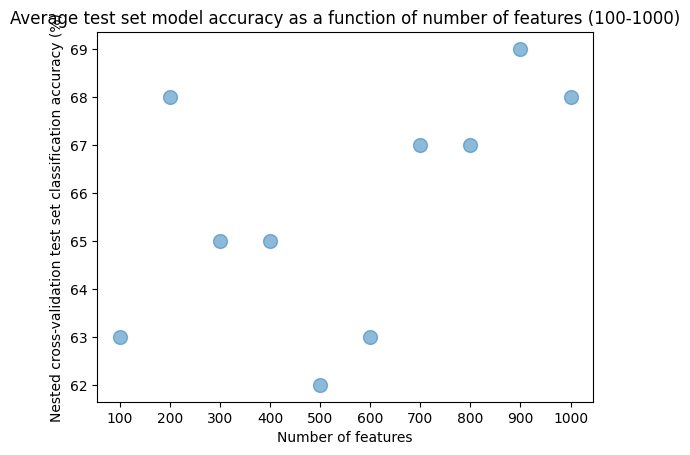

In [ ]:
mean_scores = mean(k_scores,axis=1)

# We're ready to plot
plt.style.use("default")
plt.scatter(ROIs,mean_scores, s=100, alpha = 0.5)
plt.gca().set(
    title="Average test set model accuracy as a function of number of features (100-1000)",
    xlabel="Number of features",
    ylabel="Nested cross-validation test set classification accuracy (%)",
    xticks = (ROIs)
)
plt.show()

On average, the 900-ROI model yields the highest classification accuracy. We would now further explore the 10 outer folds of this model in order to determine which of the 10 values of 'C' yields the highest performance across every set of 5 inner folds.